In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Dataset

In [2]:
df_movie = pd.read_csv('movies.csv')
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Preprocessing

In [3]:
# the function to extract titles 
def extract_title(title):
   year = title[len(title)-5:len(title)-1]
   
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
   if year.isnumeric():
      title_no_year = title[:len(title)-7]
      return title_no_year
   else:
      return title

# the function to extract years
def extract_year(title):
   year = title[len(title)-5:len(title)-1]
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
   if year.isnumeric():
      return int(year)
   else:
      return np.nan

# change the column name from title to title_year
df_movie.rename(columns={'title':'title_year'}, inplace=True) 

# remove leading and ending whitespaces in title_year
df_movie['title_year'] = df_movie['title_year'].apply(lambda x: x.strip()) 

# create the columns for title and year
df_movie['title'] = df_movie['title_year'].apply(extract_title) 
df_movie['year'] = df_movie['title_year'].apply(extract_year)

In [4]:
r,c = df_movie[df_movie['genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)
# remove the movies without genre information and reset the index
df_movies = df_movie[~(df_movie['genres']=='(no genres listed)')].reset_index(drop=True)

The number of movies which do not have info about genres: 34


Text(0, 0.5, 'Counts')

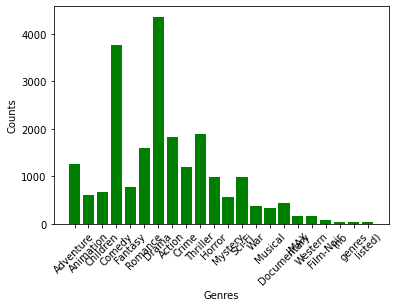

In [5]:
# remove '|' in the genres column
df_movie['genres'] = df_movie['genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in df_movie.index:
   for g in df_movie.loc[i,'genres'].split(' '):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1
# create a bar chart
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

## TF-IDF

In [6]:
# change 'Sci-Fi' to 'SciFi' and 'Film-Noir' to 'Noir'
df_movie['genres'] = df_movie['genres'].str.replace('Sci-Fi','SciFi')
df_movie['genres'] = df_movie['genres'].str.replace('Film-Noir','Noir')

# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')

# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(df_movie['genres'])

In [7]:
tfidf_matrix.shape

(9742, 21)

## Cosine Similarity

In [8]:
# create the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix)
print(sim_matrix)

[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


## Make the recommendation engine

In [9]:
# a function to convert index to title_year
def get_title_year_from_index(index):
    tmp = df_movie[df_movie.index == index]['title_year']
    if len(tmp) == 0:
        res = None
    else:
        res = tmp.values[0]
    return res

In [10]:
# a function to convert index to title
def get_title_from_index(index):
   return df_movie[df_movie.index == index]['title'].values[0]

In [11]:
# a function to convert title to index
def get_index_from_title(title):
    tmp = df_movie[df_movie.title == title]
    if len(tmp) == 0:
        res = None
    else:
        res = tmp.index.values[0]
    return res

In [12]:
def contents_based_recommender(movie_user_likes,how_many):
    simmov = []
    movie_index = get_index_from_title(movie_user_likes)
    if movie_index != None:
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
        # remove the typed movie itself
        similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) 
        for i,s in similar_movies[:how_many]:
            simmov.append(get_title_year_from_index(i))
    else:
        simmov.append("Inputed Movie Title Not Found!")
    
    return simmov

## Test

In [13]:
test = contents_based_recommender('Toy Story',10)
test

['Antz (1998)',
 'Toy Story 2 (1999)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 "Emperor's New Groove, The (2000)",
 'Monsters, Inc. (2001)',
 'Wild, The (2006)',
 'Shrek the Third (2007)',
 'Tale of Despereaux, The (2008)',
 'Asterix and the Vikings (Astérix et les Vikings) (2006)',
 'Turbo (2013)']

In [14]:
df_movie

,movieId,title_year,genres,title,year
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Toy Story,1995.0
1,2,Jumanji (1995),Adventure Children Fantasy,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy Romance,Grumpier Old Men,1995.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,Waiting to Exhale,1995.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,Black Butler: Book of the Atlantic,2017.0
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,No Game No Life: Zero,2017.0
9739,193585,Flint (2017),Drama,Flint,2017.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,Bungo Stray Dogs: Dead Apple,2018.0


In [15]:
titles = df_movie['title_year'].to_numpy()

# GUI

In [16]:
import PySimpleGUI as sg

In [17]:
def func(message):
    print(message)

input_column = [
    [
        sg.Text("Enter a Title"),
        sg.In(size=(25, 1), enable_events=False, key="-TITLE-"),
        sg.Submit(key="-SUBMIT-")
    ],
    [
        sg.Listbox(
            titles, enable_events=False, size=(40, 20), key="-TITLE LIST-", horizontal_scroll=True
        )
    ],
]

result_column = [
    [sg.Text("Choose an title from list on left!")],
    [sg.Text("Recommendation based on movie: ",size=(40, 1), key="-TOUT1-")], 
    [
        sg.Listbox(
            values = [], enable_events=False, size=(40, 20), key="-REC LIST-", horizontal_scroll=True
        )
    ],
]
    
layout = [
    [
        sg.Column(input_column),
        sg.VSeperator(),
        sg.Column(result_column),
    ],
    [sg.Exit()],
]

window = sg.Window(title="Film Recommendation", margins=(50, 50)).Layout(layout)

while True:
    event, values = window.Read()
    if event in (None, 'Exit'):
        break
    if event == "-SUBMIT-":
        key = values["-TITLE-"]
        window["-TOUT1-"].update("Recommendation based on movie: "+key)
        res = contents_based_recommender(key,15)
        window["-REC LIST-"].update(res)
window.Close()
